In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt

In [22]:
from torch.distributions import Normal

In [3]:
device = torch.device("cuda")

In [4]:
xs = np.arange(30000)/1000

In [5]:
ys = 5 * np.cos(xs) + xs

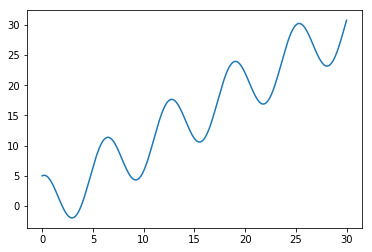

In [6]:
plt.plot(xs,ys)

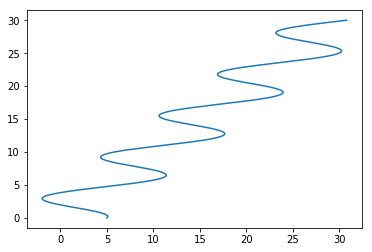

In [7]:
plt.plot(ys,xs)

In [8]:
min(ys), max(ys)

(-1.9587446178034216, 30.765316706512216)

In [195]:
new_xs_for_test = np.arange(-2, 31, 0.05)

In [10]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        
        self.fc1 = nn.Linear(1, 20).to(device)
        self.fc2 = nn.Linear(20, 20).to(device)
        self.fc3 = nn.Linear(20, 1).to(device)
        
        self.optimizer = optim.Adam(self.parameters(), lr=1e-3)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [11]:
len(ys)

30000

# Tanh Only

0 279.04333


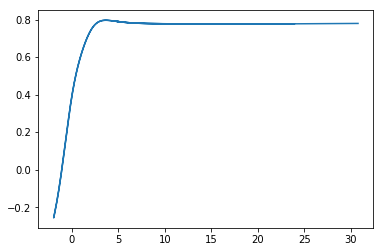

2500 10.206874


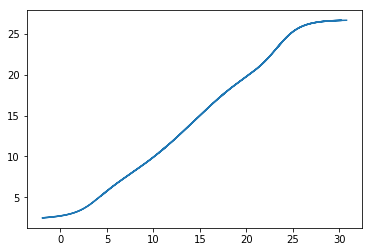

5000 9.710899


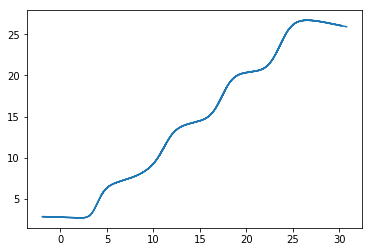

7500 9.255929


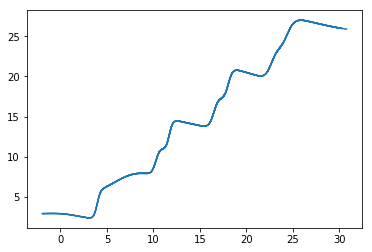

10000 7.8037066


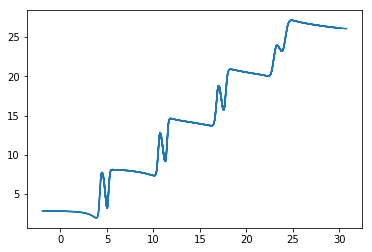

12500 7.3829684


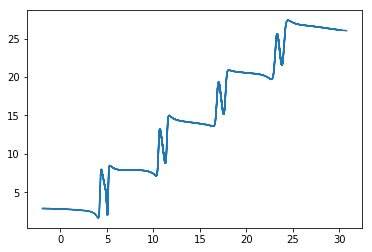

15000 7.258073


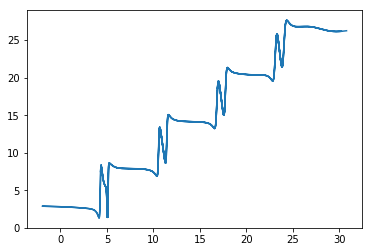

17500 7.181451


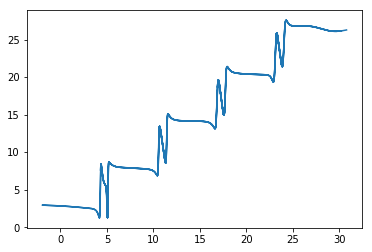

20000 7.1149135


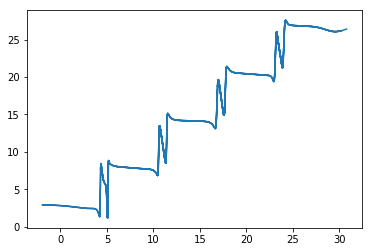

22500 7.0662637


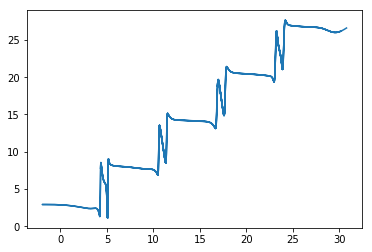

In [14]:
fcn = FCN()
for epi in range(25000):    
    sxy = list(zip(ys,xs))
    np.random.shuffle(sxy)
    sxs = torch.FloatTensor([i[0] for i in sxy]).to(device)
    sxy = torch.FloatTensor([i[1] for i in sxy]).to(device)

    epi_loss = []
    
    txs = sxs.view(-1,1)
    tys = sxy.view(-1,1)

    loss = F.mse_loss(fcn.forward(txs), tys)

    fcn.optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(fcn.parameters(), 1.0)
    fcn.optimizer.step()


    epi_loss.append((loss.detach().cpu().numpy()))
    
    if epi % 2500 == 0:
        print(epi,np.mean(epi_loss))
  

        new_ys = fcn.forward(torch.FloatTensor(ys).view(-1,1).to(device)).view(-1).detach().cpu().numpy()
        plt.plot(ys, new_ys)
        plt.show()

In [187]:
class MDN(nn.Module):
    def __init__(self, n_gaussian):
        super(MDN, self).__init__()
        
        self.fc1 = nn.Linear(1, 100).to(device)
        self.fc2 = nn.Linear(100, 100).to(device)
        
        self.mu = nn.Linear(100, n_gaussian).to(device)
        self.log_std = nn.Linear(100, n_gaussian).to(device)
        self.prob = nn.Linear(100, n_gaussian).to(device)
        
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        
        mu = self.mu(x)
        sigma = torch.exp(torch.clamp(self.log_std(x),-3,3))
        prob = F.softmax(self.prob(x), dim=1)
        
        
        return mu, sigma, prob

In [188]:
gaussian_const = ((np.pi*2) ** (1/2))
def gaussian_pdf(y, mu, sigma):
    return torch.clamp_min(torch.exp( (y-mu)**2 / (-2) / (sigma **2) ) / (sigma * gaussian_const ), 1e-3)

In [189]:
def gumbel_sample(prob):
    z = np.random.gumbel(loc = 0.0, scale = 1.0, size = prob.shape)
    return torch.argmax(torch.log(prob) + torch.FloatTensor(z).to(device), dim = 1, keepdim = True)

In [179]:
ys = ys/10
xs = xs/10

In [196]:
new_xs_for_test = new_xs_for_test / 10

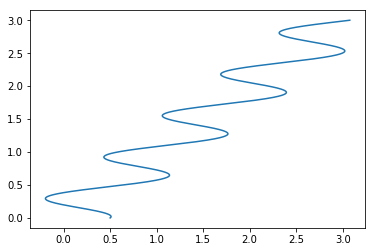

In [197]:
plt.plot(ys,xs)

In [201]:
tys.shape

torch.Size([1000, 1])

0 1.8800381


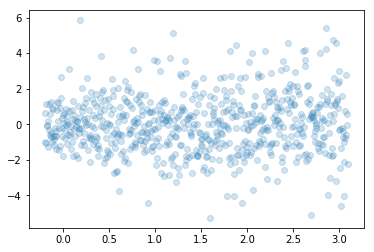

100 -0.16786744


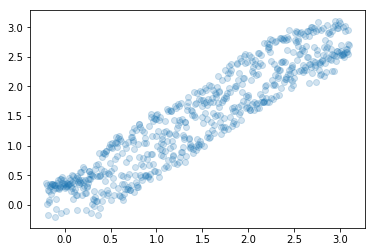

200 -0.41970617


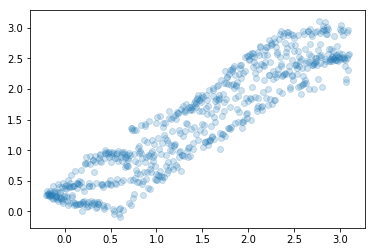

300 -0.60256535


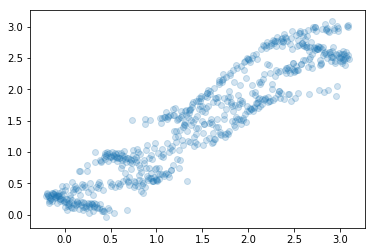

400 -0.66215825


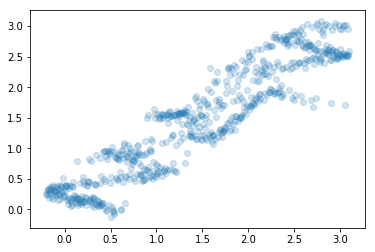

500 -0.67625684


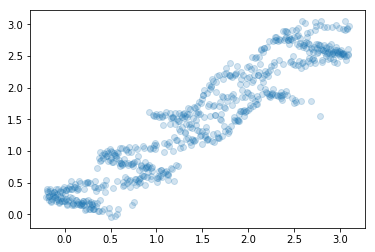

600 -0.7657725


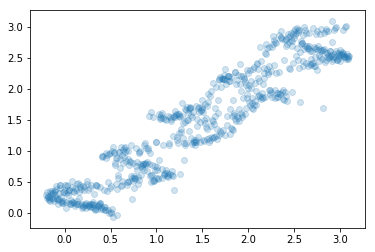

700 -0.83828074


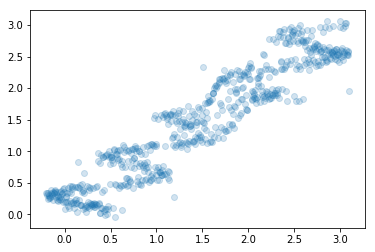

800 -0.86210847


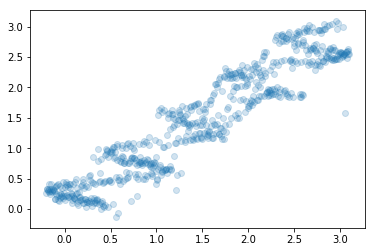

900 -0.8624666


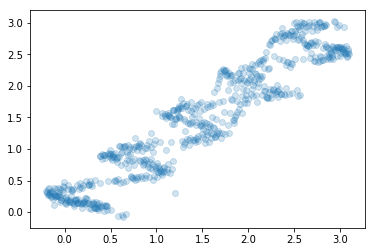

KeyboardInterrupt: 

In [202]:
mdn = MDN(n_gaussian=5)
for epi in range(100000):    
    sxy = list(zip(ys,xs))
    np.random.shuffle(sxy)
    
    for i in range(30):
        bxy = sxy[i*1000:(i+1)*1000]
    
        sxs = torch.FloatTensor([i[0] for i in bxy]).to(device)
        sys = torch.FloatTensor([i[1] for i in bxy]).to(device)

        epi_loss = []

        txs = sxs.view(-1,1)
        tys = sys.view(-1,1)

        tys_repeated = tys

        mu, sigma, prob = mdn.forward(txs)

        p_y = gaussian_pdf(tys_repeated, mu, sigma)

        loss = torch.mean(-torch.log(torch.sum(p_y * prob, dim=1)))

        mdn.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(mdn.parameters(), 1.0)
        mdn.optimizer.step()
        
 
        epi_loss.append((loss.detach().cpu().numpy()))

    if epi % 100 == 0:
        print(epi,np.mean(epi_loss))


        with torch.no_grad():

            new_mu, new_sigma, new_prob = mdn.forward(torch.FloatTensor(new_xs_for_test).view(-1,1).to(device))

            gauss_index = gumbel_sample(new_prob)

            selected_mu = torch.gather(new_mu, dim=1, index = gauss_index)
            selected_sigma = torch.gather(new_sigma, dim=1, index = gauss_index)

            new_ys = torch.randn_like(selected_mu) * selected_sigma + selected_mu
            new_ys = new_ys.detach().cpu().numpy()


        plt.scatter(new_xs_for_test, new_ys, alpha=0.2)
        plt.show()
    
